In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset/tesla-stock-price.csv')
df.head()

,date,close,volume,open,high,low
0,15-10-2018,259.59,6189026,259.06,263.28,254.5367
1,12-10-2018,258.78,7189257,261.00,261.99,252.0100
2,11-10-2018,252.23,8128184,257.53,262.25,249.0300
3,10-10-2018,256.88,12781560,264.61,265.51,247.7700
4,09-10-2018,262.80,12037780,255.25,266.77,253.3000


In [3]:
df.dtypes

date       object
close     float64
volume      int64
open      float64
high      float64
low       float64
dtype: object

In [4]:
unique_dates = df['date'].unique()
date_to_int = {date: i for i, date in enumerate(unique_dates)}
df['date'] = df['date'].map(date_to_int)

In [5]:
df.dtypes

date        int64
close     float64
volume      int64
open      float64
high      float64
low       float64
dtype: object

In [6]:
# for x in col_list:
#   if df[x].dtypes=='object' or x =='close':
#     continue

#   Q1 = df[x].quantile(0.25)
#   Q3 = df[x].quantile(0.75)

#   IQR = Q3-Q1   # Inter Quartile Range.
#   lower_bound = Q1 - 1.5*IQR
#   upper_bound = Q3 + 1.5*IQR
#   df = df[(df[x]>=lower_bound) & (df[x]<=upper_bound)]

In [7]:
X = df.drop(columns = 'close').values    #all the input columns
y = df['close'].values  #the output column

In [8]:
def train_test_split(X, y, test_size=0.3):
    split_index = int((1 - test_size) * len(X))
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def mse(self, y):
        return np.var(y) * len(y)

    def best_split(self, X, y):
        best_mse = float('inf')
        best_idx, best_val = None, None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                mse_left = self.mse(y[left_mask])
                mse_right = self.mse(y[right_mask])
                total_mse = mse_left + mse_right

                if total_mse < best_mse:
                    best_mse = total_mse
                    best_idx = feature_index
                    best_val = threshold

        return best_idx, best_val

    def build_tree(self, X, y, depth=0):
        if len(y) < self.min_samples_split or depth >= self.max_depth:
            return np.mean(y)

        feature_index, threshold = self.best_split(X, y)
        if feature_index is None:
            return np.mean(y)

        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold

        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'feature_index': feature_index,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature_value = x[tree['feature_index']]
        if feature_value <= tree['threshold']:
            return self.predict_sample(x, tree['left'])
        else:
            return self.predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])

In [10]:
class RandomForestRegressor:
    def __init__(self, n_estimators = 10, max_depth = 5, min_samples_split = 2, max_features = None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features  # Number of features to consider at each split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        
        if self.max_features is None:
            self.max_features = n_features  # Use all features if not specified
        
        for _ in range(self.n_estimators):
            # Bootstrap sampling: sample with replacement
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            # Create a tree and train it on the bootstrap sample
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            
            # Monkey patch the tree's best_split method to limit features considered per split
            def best_split_with_feature_bagging(X_sub, y_sub):
                best_mse = float('inf')
                best_idx, best_val = None, None

                features_idx = np.random.choice(n_features, self.max_features, replace=False)

                for feature_index in features_idx:
                    thresholds = np.unique(X_sub[:, feature_index])
                    for threshold in thresholds:
                        left_mask = X_sub[:, feature_index] <= threshold
                        right_mask = X_sub[:, feature_index] > threshold
                        if len(y_sub[left_mask]) == 0 or len(y_sub[right_mask]) == 0:
                            continue
                        mse_left = tree.mse(y_sub[left_mask])
                        mse_right = tree.mse(y_sub[right_mask])
                        total_mse = mse_left + mse_right

                        if total_mse < best_mse:
                            best_mse = total_mse
                            best_idx = feature_index
                            best_val = threshold

                return best_idx, best_val

            tree.best_split = best_split_with_feature_bagging

            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees (average)
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

In [11]:
rf_model = RandomForestRegressor(n_estimators = 15, max_depth = 6, max_features = 4)
rf_model.fit(X_train, y_train)

In [12]:
y_pred = rf_model.predict(X_test)

In [13]:
mse = np.mean((y_test - y_pred) ** 2)

mae = np.mean(np.abs(y_test - y_pred))

ss_total = np.sum((y_test - np.mean(y)) ** 2)
ss_res = np.sum((y_test - y_pred) ** 2)
r2 = 1 - (ss_res / ss_total)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 61.9639
Mean Absolute Error (MAE): 4.6776
R² Score: 0.9825


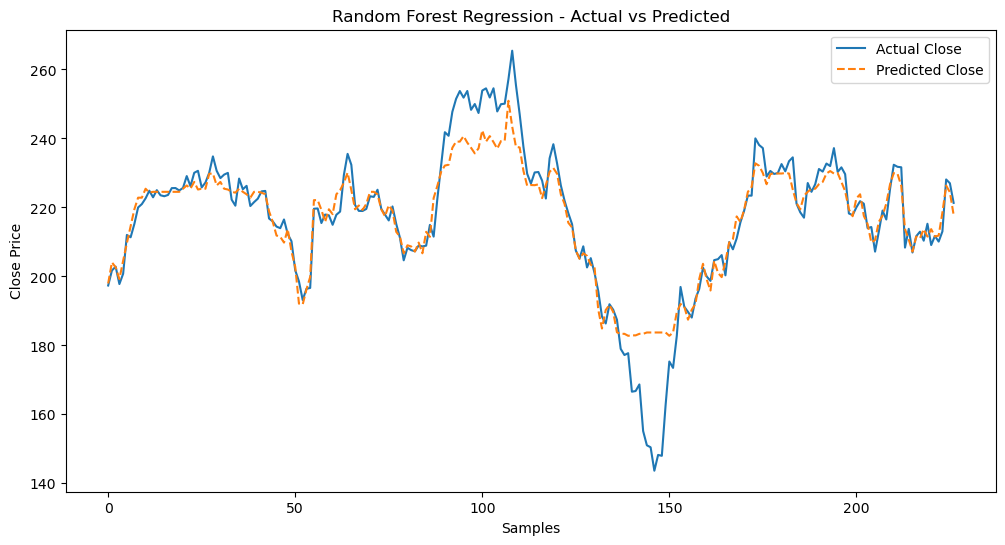

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Close')
plt.plot(y_pred, label='Predicted Close', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.title('Random Forest Regression - Actual vs Predicted')
plt.show()